In [15]:
from utils import load_embedding, parse_tup, cos_sim, cos_dist
from kaleido.scopes.plotly import PlotlyScope
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
scope = PlotlyScope()


TIME_FRAME = "monthly"
# from utils import CANDIDATE_SUBS
left_candidates = ["JoeBiden","SandersForPresident","BaemyKlobaechar","ElizabethWarren","Pete_Buttigieg","YangForPresidentHQ"]
right_candidates = ["The_Donald"]
mapping = {}
for a,b in zip(left_candidates+right_candidates,px.colors.qualitative.Plotly):
    mapping[a] = b

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [16]:
embedding = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/vecs_0.0028_15.0.txt",split=False)
embedding

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
subreddit,,,,,,,,,,,,,,,,,,,,,
SquaredCircle,0.134779,0.043821,-0.011876,-0.066840,0.020694,-0.055040,0.017334,0.004694,-0.082625,0.124690,...,-0.061495,-0.183028,-0.099551,0.031485,-0.040188,0.143292,0.040536,-0.008464,0.041863,-0.172806
AskReddit,0.135559,0.008985,-0.037187,0.000455,0.022365,-0.006085,-0.017524,0.040978,-0.054059,0.069235,...,-0.039066,-0.043172,-0.106157,0.105634,-0.045787,0.063289,0.057239,-0.198356,0.061649,-0.023330
politics,-0.042422,0.024062,-0.165820,0.046046,-0.080393,0.024717,0.044797,0.094564,-0.090970,0.013700,...,0.034073,-0.087685,-0.129094,0.110916,0.047369,0.014214,0.025798,-0.121198,0.155587,-0.057969
memes,0.002449,-0.014680,-0.031889,-0.051864,0.044783,-0.055175,0.063965,0.009760,-0.135631,0.106458,...,0.024190,-0.042757,-0.033878,0.041545,-0.001212,0.076116,0.036539,-0.102034,0.054330,-0.073219
teenagers,0.026058,0.069684,0.024581,0.009624,-0.029134,0.076384,0.078542,0.052331,-0.106552,0.096511,...,0.013686,-0.014345,-0.004146,0.055941,-0.009106,0.085962,0.030374,-0.028468,0.069988,-0.039540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NRV,0.122154,0.130032,-0.243602,-0.032611,-0.038153,-0.014279,-0.065262,-0.001528,-0.099809,-0.018441,...,-0.054521,-0.062958,-0.112747,0.098669,-0.049754,-0.015509,0.117170,-0.216936,0.008118,-0.123790
UTT,0.135902,0.057751,-0.200740,-0.035059,-0.005987,-0.000219,-0.083139,0.033362,-0.119045,0.125617,...,-0.019219,-0.092823,-0.096780,0.095344,-0.114785,0.023995,0.075017,-0.151421,0.048709,-0.065192
MMU,0.119556,0.049138,-0.134668,0.009505,0.023105,-0.025217,-0.026836,-0.026815,-0.198236,0.021817,...,-0.075906,-0.067976,-0.035603,-0.009426,-0.084691,0.068536,-0.040373,-0.134642,0.068508,-0.132696


## Create Dimensions

In [17]:
from dataclasses import dataclass

@dataclass
class Dimension:
    name: str
    subreddits: list
    tags: tuple

In [18]:
def calculate_dim(dimensions,e,return_stats=False):
    """
        Takes in a list of tuples and calcualtes the dimension from ap -> a. IE if we have the subreddits AskMen (a) and
        AskWomen (ap). The "masculine" vector transformation is a - ap.
        Returns the average transformation and a tuple containing the mean and std deviation similarity between the individual 
        transformations.
    """
    dimensions = dimensions if type(dimensions) is list else [dimensions]
    calc_trans = lambda vec_a,vec_ap : vec_a - vec_ap 
    transformations = np.array([calc_trans(e.loc[a],e.loc[ap]) for (a,ap) in dimensions])
    transformation = transformations.flatten() if transformations.shape[0] == 1 else np.mean(transformations,axis=0)
    if return_stats:
        sims = [cos_sim(t1,t2)  for t1 in list(transformations) for t2 in list(transformations) if not np.all(t1==t2)]
        return transformation, (np.mean(sims),np.std(sims))
    return transformation

project_dim = lambda dim,sub,e : cos_sim(dim,e.loc[sub])

# sorry everyone for this gross one-liner
get_closest = lambda sub,e,k=20  : list(e.apply(lambda x : cos_sim(np.array(x),e.loc[sub]),axis=1,result_type="expand").sort_values(0,ascending=False).head(k).index) 

*Reason for including /r/uncensorednews in the globalism subreddit*

>Anti-globalists. These people like Alex Jones, Steve Bannon, Sean Hannity, and conspiracy theories—and they talk about them an awful lot. They are far less enamored (yet still mildly obsessed) with George Soros, who funds everyone they hate, as well as Emmanuel Macron, John McCain, and Paul Ryan. Elsewhere, they can be seen on /r/uncensorednews (primarily news about bad things perpetrated by members of minority groups and left-wing people), and /r/conspiracy. Their hyperbolic conspiratorial language might sound absurd, but it’s become an increasingly coherent and important part of The_Donald since the subreddit began.
    **Most common words: globalist scum, the establishment, puppets, elites, masters, George Soros, cultural Marxist**

In [19]:
religious_subs = [("Christianity","exchristian"),
                  ("TraditionalCatholics","excatholic"),
                  ("lds","exmormon"),("mormon","exmormon"),("islam","exmuslim")]

ideological_subs =[("Conservative","progressive"),
                   ("Republican","democrats"),
                   ("conservatives","SocialDemocracy"),
                   ("TheNewRight","WeAreNotAsking"),
                   ("neoliberal","dsa"),
                   ("Capitalism","capitalism_in_decay"),
                   ("walkaway","LateStageImperialism")]

# ideological_subs =[("Conservative","progressive"),
#                    ("Republican","democrats"),
#                    ("conservatives","SocialDemocracy"),
#                    ("TheNewRight","WeAreNotAsking"),
#                    ("neoliberal","dsa"),
#                    ("Capitalism","dsa"),
#                    ("walkaway","ShitLiberalsSay")]

bc_subs = [("prolife","prochoice"),
           ("prolife","birthcontrol")]

gc_subs= [("Firearms","GunsAreCool"),("progun","GunsAreCool")]
age_subs = [("RedditForGrownups","teenagers"),
            ("RedditForGrownups","teenagersnew")]

war_subs = [("CredibleDefense","EndlessWar"),
            ("WarCollege","EndlessWar"),
            ("Intelligence","EndlessWar")]

glob_subs = [("neoliberal","EnoughLibertarianSpam"),
             ("Economics","capitalism_in_decay"),
             ("Libertarian","EnoughLibertarianSpam")
            ]

gender_subs = [("daddit","Mommit"),
               ("AskMen","AskWomen")]

# glob_subs = [("neoliberal","EnoughLibertarianSpam"),
#              ("Economics","EnoughLibertarianSpam"),
#              ("Libertarian","EnoughLibertarianSpam")
#             ]


religious_dim = Dimension("Religiosity",religious_subs,("More Religious","More Secular"))
ideological_dim = Dimension("Ideology",ideological_subs,("Further Right","Further Left"))
bc_dim = Dimension("Birth Control",bc_subs,("Conservative","Progressive"))
gc_dim = Dimension("Gun Control",gc_subs,("Less Regulation","More Regulation"))
age_dim = Dimension("Age",age_subs,("Older","Younger"))
war_dim = Dimension("War",war_subs,("Hawkish","Pascifistic"))
glob_dim = Dimension("Trade",glob_subs,("More Globalism","Less Globalism"))
gender_dim = Dimension("Gender",gender_subs,("Masculine","Feminine"))

dims = [religious_dim,ideological_dim,bc_dim,gc_dim,age_dim,war_dim,glob_dim,gender_dim]

In [20]:
dim_list = list(np.array(religious_subs+ideological_subs+bc_subs+[gc_subs]+age_subs+war_subs+glob_subs).flatten())+left_candidates+right_candidates
sample_subs = np.unique(np.array([get_closest(x,embedding) for x in tqdm(dim_list) if x in embedding.index]).flatten())


In [21]:
proj_df = pd.DataFrame(dict(subreddit=embedding.index)).set_index("subreddit")#.sample(n=1000,random_state=2)
proj_df = proj_df[proj_df.index.isin(sample_subs)]
d = []
for dim_info in dims:
    dim = calculate_dim(dim_info.subreddits,embedding)
    d.append(dim)
    projections = proj_df.index.map(lambda x: project_dim(dim,x,embedding))
    proj_df[dim_info.name] = projections
    
proj_df = proj_df[["Age","Religiosity","War","Trade","Gun Control","Birth Control","Ideology","Gender"]]
cols = proj_df.columns
proj_df.head()

,Age,Religiosity,War,Trade,Gun Control,Birth Control,Ideology,Gender
subreddit,,,,,,,,
politics,0.243414,-0.063403,-0.096227,0.207847,-0.154947,0.118688,0.003063,0.066796
memes,-0.478389,0.098714,-0.071418,0.075838,0.176646,0.056845,0.080937,-0.055153
teenagers,-0.665483,0.085468,-0.105366,0.030217,0.190702,0.091792,0.102938,0.012110
dankmemes,-0.571761,0.095301,-0.093333,0.021774,0.190169,0.127418,0.114865,-0.005875
The_Donald,-0.042661,0.049470,-0.192267,0.121048,0.041934,0.330947,0.386075,-0.037087


## Visualize

In [22]:
melted = proj_df.reset_index().melt(id_vars=["subreddit"], value_vars=cols,value_name="projection",var_name="dimension").sort_values("dimension",ascending=False)
fig = px.scatter(melted,
                 x="projection",
                 y="dimension",
                 opacity=0.3,
                 color="dimension",
                 labels=dict(dimension="",projection="Projection",subreddit="Subreddit"),
                )
x = abs(max(proj_df.max().max(),proj_df.min().min(),key=abs))*1.10
annotations = []

for dim_info in dims:
    annotations.append(dict(
            x=x,
            y=dim_info.name,
            xref="x",
            yref="y",
            text="<b>{}</b>".format(dim_info.tags[0]),
            showarrow=False,
            font=dict(size=16),
            ax=-40,
            ay=-30
        ))    
    annotations.append(dict(
            x=-x,
            y=dim_info.name,
            xref="x",
            yref="y",
            text=f"<b>{dim_info.tags[1]}</b>",
            showarrow=False,
            font=dict(size=16),
            ax=-40,
            ay=-50
        ))
    mx = proj_df[dim_info.name].idxmax()
    mn = proj_df[dim_info.name].idxmin()
    annotations.append(dict(
            x=proj_df.loc[mx][dim_info.name],
            y=dim_info.name,
            xref="x",
            yref="y",
            text=f"r/{mx}",
            arrowcolor="rgba(0,0,0,0)",
            font=dict(size=16),
            ax=0,
            ay=20
        ))
    annotations.append(dict(
            x=proj_df.loc[mn][dim_info.name],
            y=dim_info.name,
            xref="x",
            yref="y",
            xanchor = "right",
            text=f"r/{mn}",
            arrowcolor="rgba(0,0,0,0)",
            font=dict(size=16),
            ax=0,
            ay=20
        ))


args = {
    "font":{"size": 23},
    "height": 700,
    "width": 1000,    
    "template":"simple_white",
    "yaxis_type": 'category',
    "showlegend": False,
    "annotations": annotations,
    "yaxis":{"showline": False},
}
    
fig.update_layout(**args)
# with open("visualizations/political_dimensions/Political_Dimensions-Relevant_Subs.pdf", "wb") as f:
#     f.write(scope.transform(fig, format="pdf"))
# fig.write_html("visualizations/political_dimensions/Political_Dimensions-Relevant_Subs.html")
fig.show()

In [23]:
just_cands = proj_df[proj_df.index.isin(left_candidates)]
melted = just_cands.reset_index().melt(id_vars=["subreddit"], value_vars=cols,value_name="projection",var_name="dimension").sort_values("dimension",ascending=True)
melted["size"]=4
fig = px.scatter(melted,
                 x="projection",
                 y="dimension",
                 size="size",
                 color="subreddit",
                 color_discrete_map=mapping,
                 labels=dict(dimension="",projection="Projection",subreddit="Subreddit"),
                )
x = abs(max(just_cands.max().max(),just_cands.min().min(),key=abs))*1.10
annotations = []

for dim_info in dims:
    annotations.append(dict(
            x=x,
            y=dim_info.name,
            xref="x",
            yref="y",
            text="<b>{}</b>".format(dim_info.tags[0]),
            showarrow=False,
            font=dict(size=16),
            ax=-40,
            ay=-30
        ))    
    annotations.append(dict(
            x=-x,
            y=dim_info.name,
            xref="x",
            yref="y",
            text=f"<b>{dim_info.tags[1]}</b>",
            showarrow=False,
            font=dict(size=16),
            ax=-40,
            ay=-50
        ))


args = {
    "font":{"size": 23},
    "height": 700,
    "width": 1000,    
    "template":"simple_white",
    "yaxis_type": 'category',
    "annotations": annotations,
    "yaxis":{"showline": False},
    "legend": {"orientation":"h",
              "yanchor":"bottom",
                "y":1.02,
                "xanchor":"right",
                "x":1}
}
fig.update_layout(**args)
# with open("visualizations/political_dimensions/Political_Dimensions-Candidate_Subs.pdf", "wb") as f:
#     f.write(scope.transform(fig, format="pdf"))
# fig.write_html("visualizations/political_dimensions/Political_Dimensions-Candidate_Subs.html")
fig.show()


In [24]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    vertical_spacing=0.2,
    shared_yaxes=True,
    subplot_titles=("Sample Subreddits",
                    "Candidate Subreddits"))


annotations = []
for i,dim_info in enumerate(dims):
    n = dim_info.name
    fig.add_trace(go.Scatter(x=proj_df[n],
                             y=[n for _ in proj_df.index],
                             mode="markers",
                             marker=dict(color="grey",opacity=0.25),                         
                             showlegend=False
                            ),
                  row=1,
                  col=1)
    for cand in left_candidates:
        fig.add_trace(go.Scatter(x=[just_cands.loc[cand][n]],
                                 y=[n],
                                 mode="markers",
                                 name=cand,
                                 legendgroup=cand,
                                 showlegend = True if not i else False,
                                 marker=dict(color=mapping[cand],size=20,opacity=0.8),                         
                                ),
                      row=1,
                      col=2)
        fig.add_trace(go.Scatter(x=[just_cands.loc[cand][n]],
                                 y=[n],
                                 mode="markers",
                                 name=cand,
                                 legendgroup=cand,
                                 showlegend = False,
                                 marker=dict(color=mapping[cand],size=8.5,opacity=1),                         
                                ),
                      row=1,
                      col=1)
    x = abs(max(proj_df.max().max(),proj_df.min().min(),key=abs))*1.10
    annotations.append(dict(
            x=x,
            y=n,
            xref="x",
            yref="y",
            textangle=30,
            text="<b>{}</b>".format(dim_info.tags[0]),
            showarrow=False,
            font=dict(size=13),
            ax=0,
            ay=20
        ))    
    annotations.append(dict(
            x=-x,
            y=n,
            textangle=30,
            xref="x",
            yref="y",
            text=f"<b>{dim_info.tags[1]}</b>",
            showarrow=False,
            font=dict(size=13),
            ax=0,
            ay=20
        ))
    x = abs(max(just_cands.max().max(),just_cands.min().min(),key=abs))*1.10

    annotations.append(dict(
            x=x,
            y=n,
            xref="x2",
            yref="y2",
            textangle=30,
            text="<b>{}</b>".format(dim_info.tags[0]),
            showarrow=False,
            font=dict(size=13),
            ax=0,
            ay=20
        ))    
    annotations.append(dict(
            x=-x,
            y=n,
            textangle=30,
            xref="x2",
            yref="y2",
            text=f"<b>{dim_info.tags[1]}</b>",
            showarrow=False,
            font=dict(size=13),
            ax=0,
            ay=20
        ))
        
fig.update_yaxes(showline=False,showspikes=False,col=2)
fig.update_xaxes(title_text="Projection")
for i in fig['layout']['annotations']:
    i['font'] = dict(size=20)
    
args = {
    "font":{"size": 23},
    "height": 700,
    "width": 1000,    
    "template":"simple_white",
    "annotations": annotations,
    "yaxis_type": 'category',
    "yaxis":{"showline": False},
    "legend": {"orientation":"h",
              "yanchor":"bottom",
                "y":1.1,
                "xanchor":"right",
                "x":1}
}
fig.update_layout(**args)
# with open("visualizations/political_dimensions/Political_Dimensions-Candidate_Subs_all).pdf", "wb") as f:
#     f.write(scope.transform(fig, format="pdf"))

fig.show()

In [25]:
fig = go.Figure()
d_names = [d.name for d in dims]
vals = np.array([cos_sim(d1,d2) for d1 in d for d2 in d]).reshape(len(d),len(d))
for i in range(len(vals)):
    vals[i,i] = None
data = go.Heatmap(z=vals,y=d_names,x=d_names)#, zmin=-1, zmax=1)

layout = {
    "font":{"size": 23},
    "height": 500,
    "width": 750,    
    "template": "simple_white",
#     "xaxis": {"title": "Dimension"},
#     "yaxis": {"title": "Dimension"},
}
fig = go.Figure(data=data,layout=layout)
# with open("visualizations/political_dimensions/2019_dimension_heatmap.pdf", "wb") as f:
#     f.write(scope.transform(fig, format="pdf"))
# fig.write_html("visualizations/political_dimensions/2019_dimension_heatmap.html")
fig.show()

## Ideology Validation

Sources:https://www.pewresearch.org/pathways-2020/dem20ideo_d/digital_savviness/us_adults/
and https://www.pewresearch.org/politics/2016/07/14/voters-perceptions-of-the-candidates-traits-ideology-and-impact-on-issues/

In [27]:
cand_ideology = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/pew_ideology.csv")
cand_ideology = cand_ideology.drop(["Not sure","Refused"],axis=1).set_index("candidate")
cand_ideology

def survey_to_num(x):
    """
        Note: since the 2016 survey that included Donald Trump only had 5 categories instead of 7 the column names don't
        line up for his values, which were "Entirely Liberal","Mostly Liberal","A Mix","Mostly Conservative","Entirely Conservative"
        this function creates a linear scale from -1 to 1 using the non-nan values in each rows columns. So for most candidates
        this means the scale goes [-1, -0.66,...,0.66,1], but for Trump goes [-1,-0.5,...,0.5,1]
    """
    weights = x.dropna()
    scale = np.linspace(-1,1,len(weights))
    return sum(weights * scale)/sum(weights)
# Take the weighted average of how liberal/conservative the surveyed individuals thoguht each candidate was
# -1 indicates 100% of people thinking that candidate is 'very liberal' and 1 indicates 100% of people thinking
# that candidate is 'very conservative'
cand_ideology["pew_ideology"] = cand_ideology.apply(survey_to_num,axis=1)
cand_ideology = cand_ideology[["pew_ideology"]]
cand_ideology

,pew_ideology
candidate,
Biden,-0.274262
Sanders,-0.726190
Warren,-0.604444
Buttigieg,-0.398010
Klobuchar,-0.285714
Trump,0.221053


In [28]:
cands = ["JoeBiden","SandersForPresident","ElizabethWarren","Pete_Buttigieg","BaemyKlobaechar","The_Donald"]
i_dim = calculate_dim(ideological_dim.subreddits,embedding)
cand_ideology["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cands]
cand_ideology

,pew_ideology,reddit_projection
candidate,,
Biden,-0.274262,-0.065889
Sanders,-0.726190,-0.194282
Warren,-0.604444,-0.254581
Buttigieg,-0.398010,-0.121241
Klobuchar,-0.285714,-0.097518
Trump,0.221053,0.386075


In [42]:
import statsmodels.formula.api as smf

def fit_lin_regression(y,x,df):
    model = smf.ols(f"{y} ~ {x}",df).fit()
    print(model.summary())
    return model.rsquared
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("pew_ideology","reddit_projection",cand_ideology)

                            OLS Regression Results                            
Dep. Variable:           pew_ideology   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     32.08
Date:                Sun, 10 Jan 2021   Prob (F-statistic):            0.00479
Time:                        18:54:12   Log-Likelihood:                 5.2844
No. Observations:                   6   AIC:                            -6.569
Df Residuals:                       4   BIC:                            -6.985
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2656      0.05

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



In [44]:
xmin, xmax = cand_ideology["reddit_projection"].min()-0.2,cand_ideology["reddit_projection"].max()+0.2
ymin, ymax = cand_ideology["pew_ideology"].min()*1.10,cand_ideology["pew_ideology"].max()+0.05

args = {
    "x": "reddit_projection",
    "y": "pew_ideology",
    "text": cand_ideology.index,
    "size": [6 for _ in cand_ideology.index],
#     "title":  "Ideology Dimension Versus Support by Ideology",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Ideology", "pew_ideology": "Surveyed Ideology"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
    "trendline":"ols"
}

dt = cand_ideology.loc["Trump"]
dtx, dty = float(dt["reddit_projection"]), float(dt["pew_ideology"])

annotations = [dict(x=xmin*0.8,y=ymin*0.92,xref="x",yref="y", text="<b>Survey Left<br>Subreddit Left</b>",showarrow=False),
               dict(x=xmax*0.8,y=ymin*0.92,xref="x",yref="y", text="<b>Subreddit Right</b>",showarrow=False),
               dict(x=xmin*0.75,y=ymax,xref="x",yref="y", text="<b>Survey Right</b>",showarrow=False),
               dict(x=dtx,y=dty,xref="x",yref="y",ax=80,ay=-10, text="Data from 2016")
              ]
x = np.linspace(xmin,xmax,num=2)
    
fig = px.scatter(cand_ideology,**args)

fig.update_traces(textposition='bottom center')

args = {
    "font":{"size": 23},
    "height": 600,
    "width": 1000,    
    "template":"simple_white",
    "annotations": annotations
}
fig.update_layout(**args)
# fig.write_html("visualizations/political_dimensions/Pew_Research-Ideology_dim.html")
fig.show()

### Big Boy Pew Survey

Citation: Pew Research Center, January 2020, “As Voting Begins, Democrats Are Upbeat  about  the 2020 Field, Divided  in  Their Preferences”

In [45]:
pew_survey = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/pew-dem-primary-detailed-tables.csv",skiprows=2).set_index(["Dimension","Demographic"])
cands = ["Biden","Sanders","Warren","Buttigieg","Yang","Klobuchar"]
cand_subs = ["JoeBiden","Pete_Buttigieg","BaemyKlobaechar","SandersForPresident","ElizabethWarren","YangForPresidentHQ"]

pew_survey = pew_survey.iloc[:-1]
pew_survey = pew_survey[cands]
pew_dims = np.unique(pew_survey.index.get_level_values(0))
pew_survey

Biden  \
Dimension             Demographic                                             
Total                 All Dem/Lean Dem registered voters               26.0   
Sex                   Men                                              26.0   
                      Women                                            26.0   
Race                  White non-Hispanic                               24.0   
                      Black non-Hispanic                               36.0   
...                                                                     ...   
Race/ethnicity by age White non-Hispanic, 50+                          33.0   
                      Black non-Hispanic, 50+                          45.0   
                      Hispanic, 50+                                    36.0   
Party Identifiers     Democratic identifier                            30.0   
                      Democratic leaner (Independent/Other party/DK)   18.0   

                                                                      Sanders  \
Dimension             Demographic                                               
Total                 All Dem/Lean Dem registered voters                 21.0   
Sex                   Men                                                24.0   
                      Women                                              19.0   
Race                  White non-Hispanic                                 21.0   
                      Black non-Hispanic                                 13.0   
...                                                                       ...   
Race/ethnicity by age White non-Hispanic, 50+                            11.0   
                      Black non-Hispanic, 50+                             7.0   
                      Hispanic, 50+                                      21.0   
Party Identifiers     Democratic identifier                              19.0   
                      Democratic leaner (Independent/Other party/DK)     24.0   

                                                                      Warren  \
Dimension             Demographic                                              
Total                 All Dem/Lean Dem registered voters                16.0   
Sex                   Men                                               15.0   
                      Women                                             16.0   
Race                  White non-Hispanic                                19.0   
                      Black non-Hispanic                                 9.0   
...                                                                      ...   
Race/ethnicity by age White non-Hispanic, 50+                           16.0   
                      Black non-Hispanic, 50+                            7.0   
                      Hispanic, 50+                                      6.0   
Party Identifiers     Democratic identifier                             17.0   
                      Democratic leaner (Independent/Other party/DK)    14.0   

                                                                      Buttigieg  \
Dimension             Demographic                                                 
Total                 All Dem/Lean Dem registered voters                    7.0   
Sex                   Men                                                   7.0   
                      Women                                                 7.0   
Race                  White non-Hispanic                                   10.0   
                      Black non-Hispanic                                    0.0   
...                                                                         ...   
Race/ethnicity by age White non-Hispanic, 50+                              12.0   
                      Black non-Hispanic, 50+                               0.0   
                      Hispanic, 50+                                         2.0   
Party Identifiers     Democratic i

In [46]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(pew_dims),
    cols=1,
    subplot_titles=pew_dims)
for i,(dim, dim_df) in enumerate(pew_survey.groupby(level=0)):
    row = i+1
    col = 1

    dim_df = dim_df.reset_index()
    for _,demog in dim_df.iterrows():
        fig.add_trace(go.Bar(name=demog["Demographic"], x=cands, y=demog[cands],legendgroup=dim),
                      row=row,
                      col=col)

fig.update_layout(font=dict(size=17),height=4500,title_text="<b>Pew Research Center Democratic Primary Survey</b>")
# fig.write_html("visualizations/political_dimensions/Pew_Research_Center_Democratic_Primary_Survey.html")
fig.show()

## Age Validation

Going to test how well the age of a candidates supporters lines up with the dimension, and also how well the age of the candidate lines up with the dimension (harder to quantify if there policies benefit older vs younger folks)

**NOTE:** Age would be age when they took office.

In [47]:
age_df = pd.pivot_table(pew_survey.loc["Age (detailed)",:].reset_index(), values=cands, columns=['Demographic'])
age_df.columns = age_df.columns.rename("candidate")
age_df["age"] = age_df.apply(survey_to_num,axis=1)
i_dim = calculate_dim(age_dim.subreddits,embedding)
age_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]
age_df = age_df[["age","reddit_projection"]]
age_df

candidate,age,reddit_projection
Biden,0.249573,0.107850
Buttigieg,0.120000,0.088497
Klobuchar,0.370370,0.101380
Sanders,-0.322917,0.014061
Warren,-0.113095,0.143491
Yang,-0.614035,-0.072915


In [48]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","age",age_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     7.380
Date:                Sun, 10 Jan 2021   Prob (F-statistic):             0.0532
Time:                        18:54:52   Log-Likelihood:                 10.374
No. Observations:                   6   AIC:                            -16.75
Df Residuals:                       4   BIC:                            -17.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0726      0.022      3.343      0.0

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



In [49]:
xmin, xmax = age_df["reddit_projection"].min()*1.3,age_df["reddit_projection"].max()*1.3
ymin, ymax = age_df["age"].min()*1.3,age_df["age"].max()*1.3

args = {
    "x": "reddit_projection",
    "y": "age",
    "text": age_df.index,
    "title":  "Subreddit Age Dimension Versus Support by Age",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Age", "age": "Surveyed Age"},
    "range_x": [xmin,xmax],
    "trendline": "ols",
    "range_y": [ymin,ymax],
}

annotations = [dict(x=xmin*0.6,y=ymin*0.92,xref="x",yref="y", text="<b>Support Trends Young<br>Subreddit Trends Young</b>",showarrow=False),
               dict(x=xmax*0.8,y=ymin*0.92,xref="x",yref="y", text="<b>Subreddit Trends Old</b>",showarrow=False),
               dict(x=xmin*0.55,y=ymax,xref="x",yref="y", text="<b>Support Trends Old</b>",showarrow=False),
              ]
    
fig = px.scatter(age_df,**args)

fig.update_traces(textposition='bottom center')

fig.update_layout(font=dict(size=22),annotations=annotations)
# fig.write_html("visualizations/political_dimensions/Pew_Research-Age_dim.html")
fig.show()

### Age Dim Against Candidate Ages

This is a good way of maybe showing that the dimension taps more into dimensions of a supporter vs the actual candidate

In [50]:
cand_age_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/candidate_ages.csv")
cand_age_df = cand_age_df.set_index("candidate")

i_dim = calculate_dim(age_dim.subreddits,embedding)
cand_age_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]

cand_age_df = cand_age_df[["age_at_inauguration","reddit_projection"]]
cand_age_df

,age_at_inauguration,reddit_projection
candidate,,
Biden,78,0.107850
Buttigieg,38,0.088497
Klobuchar,60,0.101380
Sanders,79,0.014061
Warren,71,0.143491
Yang,45,-0.072915


In [51]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","age_at_inauguration",cand_age_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                    0.4739
Date:                Sun, 10 Jan 2021   Prob (F-statistic):              0.529
Time:                        18:55:18   Log-Likelihood:                 7.5729
No. Observations:                   6   AIC:                            -11.15
Df Residuals:                       4   BIC:                            -11.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0286    

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



*I don't think we need to visualize this one lol*

** **

## Gender Validation

In [52]:
gender_df = pd.pivot_table(pew_survey.loc["Sex",:].reset_index(), values=cands, columns=['Demographic'])
gender_df.columns = gender_df.columns.rename("candidate")
gender_df
gender_df["gender"] = np.log(gender_df["Men"]/gender_df["Women"])
gender_df
i_dim = calculate_dim(gender_dim.subreddits,embedding)
gender_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]
gender_df

candidate,Men,Women,gender,reddit_projection
Biden,26.0,26.0,0.000000,-0.105004
Buttigieg,7.0,7.0,0.000000,-0.090979
Klobuchar,2.0,3.0,-0.405465,-0.175800
Sanders,24.0,19.0,0.233615,0.074449
Warren,15.0,16.0,-0.064539,-0.162769
Yang,5.0,2.0,0.916291,-0.021445


In [53]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","gender",gender_df)
r2

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     2.827
Date:                Sun, 10 Jan 2021   Prob (F-statistic):              0.168
Time:                        18:55:21   Log-Likelihood:                 7.8321
No. Observations:                   6   AIC:                            -11.66
Df Residuals:                       4   BIC:                            -12.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0957      0.034     -2.809      0.0

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



0.4140714216765735

## Against Actual Sex of Canddiate


Bad key "text.kerning_factor" on line 4 in
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


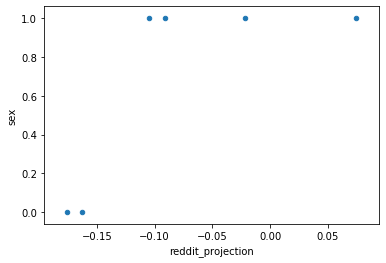

In [54]:
sexs = {"Biden": {"sex":1},
        "Buttigieg": {"sex":1},
        "Klobuchar": {"sex":0},
        "Sanders": {"sex":1},
        "Warren": {"sex":0},
        "Yang": {"sex":1}}
cand_sex_df = pd.DataFrame(sexs).T
cand_sex_df["reddit_projection"] = gender_df["reddit_projection"]
cand_sex_df.plot.scatter(x="reddit_projection",y="sex")

In [56]:
# Fit a linear regression to our model and its results
model = smf.ols(formula = f"reddit_projection ~ C(sex)",
                  data=cand_sex_df).fit()
model.summary()

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      reddit_projection   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4.690
Date:                Sun, 10 Jan 2021   Prob (F-statistic):             0.0963
Time:                        18:55:36   Log-Likelihood:                 8.5560
No. Observations:                   6   AIC:                            -13.11
Df Residuals:                       4   BIC:                            -13.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1693      0.050     -3.362      0.028      -0.309      -0.029
C(sex)[T.1]     0.1335      0.062      2.166      0.096      -0.038       0.305
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.331
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.543
Skew:                           0.713   Prob(JB):                        0.762
Kurtosis:                       2.623   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Religiosity Validation

In [57]:
religion_df = pd.pivot_table(pew_survey.loc["Religious attendance",:].reset_index(), values=cands, columns=['Demographic'])
religion_df.columns = religion_df.columns.rename("candidate")
religion_df = religion_df[["Never","Seldom","Monthly/yearly","Once a week+"]]
religion_df["religiosity"] = religion_df.apply(survey_to_num,axis=1)
i_dim = calculate_dim(religious_dim.subreddits,embedding)
religion_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]
religion_df = religion_df[["religiosity","reddit_projection"]]
religion_df

candidate,religiosity,reddit_projection
Biden,0.196429,0.030848
Buttigieg,-0.128205,-0.075191
Klobuchar,0.200000,0.024064
Sanders,-0.222222,-0.078054
Warren,-0.177778,-0.127007
Yang,-0.142857,0.003699


In [58]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","religiosity",religion_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     6.940
Date:                Sun, 10 Jan 2021   Prob (F-statistic):             0.0579
Time:                        18:55:41   Log-Likelihood:                 11.436
No. Observations:                   6   AIC:                            -18.87
Df Residuals:                       4   BIC:                            -19.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0246      0.019     -1.321      

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



In [59]:
xmin, xmax = religion_df["reddit_projection"].min()*1.3,religion_df["reddit_projection"].max()*1.5
ymin, ymax = religion_df["religiosity"].min()*1.3,religion_df["religiosity"].max()*1.3

args = {
    "x": "reddit_projection",
    "y": "religiosity",
    "text": religion_df.index,
    "title":  "Subreddit Religiosity Dimension Versus Support by Religious Attendance",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit religiosity", "religiosity": "Surveyed religiosity"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
    "trendline": "ols"
}

annotations = [dict(x=xmin*0.8,y=ymin*0.9,xref="x",yref="y", text="<b>Support Trends Secular<br>Subreddit Trends Secular</b>",showarrow=False),
               dict(x=xmax*0.8,y=ymin*0.92,xref="x",yref="y", text="<b>Subreddit Trends Religious</b>",showarrow=False),
               dict(x=xmin*0.77,y=ymax,xref="x",yref="y", text="<b>Support Trends Religious</b>",showarrow=False),
              ]
    
fig = px.scatter(religion_df,**args)

fig.update_traces(textposition='bottom center')
fig.update_layout(font=dict(size=22),annotations=annotations)
# fig.write_html("visualizations/political_dimensions/Pew_Research-religiosity_dim.html")
fig.show()

## War Validation

In [60]:
war_df = pd.pivot_table(pew_survey.loc["Veteran (self)",:].reset_index(), values=cands, columns=['Demographic'])
war_df.columns = war_df.columns.rename("candidate")
war_df = war_df[["No, no veteran in household","No, but veteran in household","Yes, self"]]
war_df["veteran"] = war_df.apply(survey_to_num,axis=1)
i_dim = calculate_dim(war_dim.subreddits,embedding)
war_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]
war_df = war_df[["veteran","reddit_projection"]]
war_df

candidate,veteran,reddit_projection
Biden,0.129032,-0.159423
Buttigieg,-0.052632,-0.132106
Klobuchar,0.250000,-0.097598
Sanders,-0.016949,-0.259093
Warren,-0.125000,-0.244371
Yang,-0.111111,-0.220962


In [62]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","veteran",war_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     4.446
Date:                Sun, 10 Jan 2021   Prob (F-statistic):              0.103
Time:                        18:56:22   Log-Likelihood:                 10.637
No. Observations:                   6   AIC:                            -17.27
Df Residuals:                       4   BIC:                            -17.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1895      0.021     -9.185      0.0

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



In [64]:
xmin, xmax = war_df["reddit_projection"].min()*1.5,war_df["reddit_projection"].max()+0.05
ymin, ymax = war_df["veteran"].min()*1.3,war_df["veteran"].max()*1.1

args = {
    "x": "reddit_projection",
    "y": "veteran",
    "text": war_df.index,
    "title":  "Subreddit Hawkish Dimension Versus Support by Military Households",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Military Dimension", "veteran": "Support by Military Households"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
    "trendline": "ols"
}

annotations = [dict(x=xmin*0.82,y=ymin*0.87,xref="x",yref="y", text="<b>Less Veteran Support<br>Subreddit Trends Pascifistic</b>",showarrow=False),
               dict(x=xmax,y=ymin*0.9,xref="x",yref="y", text="<b>Subreddit Trends Hawkish</b>",showarrow=False),
               dict(x=xmin*0.85,y=ymax,xref="x",yref="y", text="<b>More Veteran Support</b>",showarrow=False),
              ]
    
fig = px.scatter(war_df,**args)

fig.update_traces(textposition='bottom center')
               

fig.update_layout(font=dict(size=22),annotations=annotations)
# fig.write_html("visualizations/political_dimensions/Pew_Research-veteran_dim.html")
fig.show()

### War Validation vs War Policy

Source: https://www.politico.com/2020-election/candidates-views-on-the-issues/military/

In [65]:
war_policy_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/poltico_military_policy.csv")
war_policy_df = war_policy_df.set_index("candidate")[["pascifistic_policies","hawkish_policies"]]
war_policy_df["politico_policy"] = war_policy_df.apply(survey_to_num,axis=1)

i_dim = calculate_dim(war_dim.subreddits,embedding)
war_policy_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]

war_policy_df = war_policy_df[["politico_policy","reddit_projection"]]
war_policy_df

,politico_policy,reddit_projection
candidate,,
Biden,1.0,-0.159423
Buttigieg,0.0,-0.132106
Klobuchar,0.0,-0.097598
Sanders,-1.0,-0.259093
Warren,-1.0,-0.244371
Yang,0.0,-0.220962


In [66]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","politico_policy",war_policy_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     2.827
Date:                Sun, 10 Jan 2021   Prob (F-statistic):              0.168
Time:                        18:57:19   Log-Likelihood:                 9.9991
No. Observations:                   6   AIC:                            -16.00
Df Residuals:                       4   BIC:                            -16.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1763      0.024     

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



## Birth Control Dimension

Source: https://www.nytimes.com/2019/11/25/us/politics/democratic-candidates-abortion-survey.html

Note that this is a measure of how many *policies* that increase access to birth control/abortion. NOT a measure of how the supporters feel.

> [tl;dr: Andrew Yang is an amazing candidate. But, if I think abortion should be made illegal, how can I vote for a candidate who does not agree? I'm genuinely conflicted and would like some opinions.](https://www.reddit.com/r/YangForPresidentHQ/comments/dero9g/i_am_antiabortion_and_im_torn_between_voting_for/)

Also makes sense as Yang postitioned his 'freedom dividend' as a means *to reduce the number of abortions* which could also appeal to Democrats who are less comfortable with abortion.


In [67]:
bc_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/nyt_abortion_policy.csv")
bc_df = bc_df.set_index("candidate")
bc_df["nyt_policy"] = bc_df.apply(survey_to_num,axis=1)

i_dim = calculate_dim(bc_dim.subreddits,embedding)
bc_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]

bc_df = bc_df[["nyt_policy","reddit_projection"]]
bc_df

,nyt_policy,reddit_projection
candidate,,
Biden,-0.5000,0.144449
Buttigieg,-0.8750,0.003811
Klobuchar,-0.7500,0.033125
Sanders,-0.8750,0.045208
Warren,-0.9375,-0.023265
Yang,-0.8750,0.177908


In [68]:
# Fit a linear regression to our model and its results
r2 = fit_lin_regression("reddit_projection","nyt_policy",bc_df)

                            OLS Regression Results                            
Dep. Variable:      reddit_projection   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     1.326
Date:                Sun, 10 Jan 2021   Prob (F-statistic):              0.314
Time:                        18:57:50   Log-Likelihood:                 8.0478
No. Observations:                   6   AIC:                            -12.10
Df Residuals:                       4   BIC:                            -12.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2634      0.176      1.493      0.2

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



In [69]:
xmin, xmax = bc_df["reddit_projection"].min()-0.05,bc_df["reddit_projection"].max()+0.05
ymin, ymax = bc_df["nyt_policy"].min()*1.3,bc_df["nyt_policy"].max()+0.1

args = {
    "x": "reddit_projection",
    "y": "nyt_policy",
    "size": [4 for _ in bc_df.index],
    "text": bc_df.index,
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Birth Control", "nyt_policy": "Birth Control Policy"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
    "trendline": "ols"
}

annotations = [dict(x=xmax-0.06,
                    y=ymin*0.95,
                    xref="x",
                    yref="y",
                    text="<b>Subreddit Trends Pro-Life</b>",showarrow=False),
               dict(x=xmin+0.065,
                    y=ymax,
                    xref="x",
                    yref="y",
                    text="<b>Less Progressive Policies</b>",
                    showarrow=False),
              ]
    
fig = px.scatter(bc_df,**args)

fig.update_traces(textposition='bottom center')


args = {
    "font":{"size": 23},
    "height": 400,
    "width": 1000,    
    "template":"simple_white",
    "annotations": annotations
}
fig.update_layout(**args)
with open("visualizations/political_dimensions/NYT_survey-bc_over_sex_dim.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf"))
# fig.write_html("visualizations/political_dimensions/NYT_survey-bc_over_sex_dim.html")
fig.show()

## Gun Control Dimension

Source: https://www.pewresearch.org/politics/2020/01/30/political-values-and-democratic-candidate-support/#most-democratic-voters-say-gun-laws-in-this-country-should-be-stricter

In [91]:
gc_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/pew_gun_control.csv")
gc_df = gc_df.set_index("candidate")[["More","None","Less"]]
gc_df["gc_survey"] = gc_df.apply(survey_to_num,axis=1)

i_dim = calculate_dim(gc_dim.subreddits,embedding)
gc_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in ["JoeBiden","SandersForPresident","ElizabethWarren","Pete_Buttigieg"]]

gc_df = gc_df[["gc_survey","reddit_projection"]]
gc_df

,gc_survey,reddit_projection
candidate,,
Biden,-0.930000,-0.317430
Sanders,-0.878788,-0.158809
Warren,-0.970000,-0.361230
Buttigieg,-0.950000,-0.298685


In [92]:
# Fit a linear regression to our model and its results
model = np.polyfit(gc_df["reddit_projection"], gc_df["gc_survey"], 1)
predict = np.poly1d(model)
r2 = r2_score(gc_df["gc_survey"], predict(gc_df["reddit_projection"]))
r2

0.9071131062603021

In [93]:
xmin, xmax = gc_df["reddit_projection"].min()*1.1,gc_df["reddit_projection"].max()+0.05
ymin, ymax = gc_df["gc_survey"].min()-0.02,gc_df["gc_survey"].max()+0.01

args = {
    "x": "reddit_projection",
    "y": "gc_survey",
    "text": gc_df.index,
    "size": [4 for _ in gc_df.index],
#     "title":  "Subreddit Gun Control Dimension Versus Support for Gun Control",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Gun Control", "gc_survey": "Surveyed Gun Control"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
}

annotations = [
               dict(x=xmax-0.06,
                    y=ymin*0.992,
                    xref="x",
                    yref="y",
                    text="<b>Subreddit Trends Less Regulation</b>",
                    showarrow=False),
               dict(x=xmin*0.78,
                    y=ymax,
                    xref="x",
                    yref="y",
                    text="<b>Survey Trends Toward Less Regulation</b>",
                    showarrow=False),
               dict(x=-0.2,y=predict(-0.2),xref="x",yref="y", text="r<sup>2</sup>={:.2f}".format(r2)),
              ]
x = np.linspace(xmin,xmax,num=2)
    
fig = px.scatter(gc_df,**args)

fig.update_traces(textposition='bottom center')
fig.add_scatter(x=x,
                y=predict(x),
                mode='lines',
                line=dict(dash="dash",width=5,color="rgba(0,0,160,0.3)"),
                name="Linear Regression",
                showlegend=False
               )


args = {
    "font":{"size": 23},
    "height": 400,
    "width": 1000,    
    "template":"simple_white",
    "annotations": annotations
}
fig.update_layout(**args)
with open("visualizations/political_dimensions/Pew_Research-gc_dim.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf"))
fig.write_html("visualizations/political_dimensions/Pew_Research-gc_dim.html")
fig.show()

### Validating against gun control policy

Source: https://www.politico.com/2020-election/candidates-views-on-the-issues/gun-control/

Since the democratic party overwhelmingly is in favour of gun control, if a candidate didn't have a stance on gun regulation it was put in the more "less regulation" bucket

In [19]:
gc_policy_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/politico_gun_policy.csv")
gc_policy_df = gc_policy_df.set_index("candidate")
gc_policy_df["gc_policy"] = gc_policy_df.apply(survey_to_num,axis=1)

i_dim = calculate_dim(gc_dim.subreddits,embedding)
gc_policy_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]

gc_policy_df = gc_policy_df[["gc_policy","reddit_projection"]]
gc_policy_df

,gc_policy,reddit_projection
candidate,,
Biden,-0.333333,-0.317430
Buttigieg,-0.666667,-0.298685
Klobuchar,-0.333333,-0.292124
Sanders,0.000000,-0.158809
Warren,-0.333333,-0.361230
Yang,-0.666667,0.002044


In [20]:
# Fit a linear regression to our model and its results
model = np.polyfit(gc_policy_df["reddit_projection"], gc_policy_df["gc_policy"], 1)
predict = np.poly1d(model)
r2 = r2_score(gc_policy_df["gc_policy"], predict(gc_policy_df["reddit_projection"]))
r2

0.03826700374898806

In [105]:
xmin, xmax = gc_policy_df["reddit_projection"].min()*1.1,gc_policy_df["reddit_projection"].max()+0.05
ymin, ymax = gc_policy_df["gc_policy"].min()-0.04,gc_policy_df["gc_policy"].max()+0.01

args = {
    "x": "reddit_projection",
    "y": "gc_policy",
    "text": gc_policy_df.index,
    "title":  "Subreddit Gun Control Dimension Versus Gun Control Policies",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Gun Control", "gc_policy": "Gun Control Policies"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
}

annotations = [dict(x=xmin*0.7,y=ymin*0.88,xref="x",yref="y", text="<b>More Gun Control Policies<br>Subreddit Trends Toward Regulation</b>",showarrow=False),
               dict(x=xmax,y=ymin*0.89,xref="x",yref="y", text="<b>Subreddit Trends Less Regulation</b>",showarrow=False),
               dict(x=xmin*0.7,y=ymax*0.89,xref="x",yref="y", text="<b>Fewer Gun Control Policies</b>",showarrow=False),
               dict(x=-0.2,y=predict(-0.2),xref="x",yref="y", text="r<sup>2</sup>={:.2f}".format(r2)),
              ]
x = np.linspace(xmin,xmax,num=2)
    
fig = px.scatter(gc_policy_df,**args)

fig.update_traces(textposition='bottom center')
fig.add_scatter(x=x,
                y=predict(x),
                mode='lines',
                line=dict(dash="dash",width=2,color="rgba(0,0,160,0.3)"),
                name="Linear Regression"
               )

fig.update_layout(font=dict(size=22),annotations=annotations)
fig.write_html("visualizations/political_dimensions/Politic_policy-gc_dim.html")
fig.show()

## Trade/Globalism Dimension

Indirect Validation: https://www.pewresearch.org/politics/2020/01/30/political-values-and-democratic-candidate-support/#most-democratic-voters-say-gun-laws-in-this-country-should-be-stricter#positive-views-of-free-trade-agreements-cross-party-lines

Direct Validation: https://www.piie.com/blogs/trade-investment-policy-watch/where-do-democratic-presidential-candidates-stand-trade

### Indirect Validation

In [186]:
trade_df = pd.read_csv('external_datasets/polling_data/pew_trade.csv').set_index("candidate")
trade_df["trade_view"] = trade_df.apply(survey_to_num,axis=1)
i_dim = calculate_dim(glob_dim.subreddits,embedding)
trade_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in ["JoeBiden","SandersForPresident","ElizabethWarren","Pete_Buttigieg"]]
trade_df = trade_df[["trade_view","reddit_projection",]]
trade_df

,trade_view,reddit_projection
candidate,,
Biden,0.347368,0.125099
Sanders,0.448980,-0.040599
Warren,0.634409,0.051586
Buttigieg,0.705263,0.178996


In [187]:
# Fit a linear regression to our model and its results
model = np.polyfit(trade_df["reddit_projection"], trade_df["trade_view"], 1)
predict = np.poly1d(model)
r2 = r2_score(trade_df["trade_view"], predict(trade_df["reddit_projection"]))
r2

0.1147112186512006

In [191]:
xmin, xmax = trade_df["reddit_projection"].min()*1.3,trade_df["reddit_projection"].max()+0.05
ymin, ymax = trade_df["trade_view"].min()*1.3,trade_df["trade_view"].max()*1.1
args = {
    "x": "reddit_projection",
    "y": "trade_view",
    "text": trade_df.index,
    "title":  "Subreddit Globalism Dimension Versus Survey on Free Trade",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Globalism", "trade_view": "Opinion on Trade Agreements"},
}

annotations = [dict(x=xmin+0.06,y=ymin*0.88,xref="x",yref="y", text="<b>Labelled Protectionist<br>Subreddit Trends Pascifistic</b>",showarrow=False),
               dict(x=xmax,y=ymin*0.9,xref="x",yref="y", text="<b>Subreddit Trends Hawkish</b>",showarrow=False),
               dict(x=xmin+0.04,y=ymax,xref="x",yref="y", text="<b>Labelled Pro-Trade</b>",showarrow=False),
               dict(x=0.05,y=predict(0.05),xref="x",yref="y", text="r<sup>2</sup>={:.2f}".format(r2)),
              ]
x = np.linspace(xmin,xmax,num=2)
    
fig = px.scatter(trade_df,**args)

fig.update_traces(textposition='bottom center')
fig.add_scatter(x=x,
                y=predict(x),
                mode='lines',
                line=dict(dash="dash",width=2,color="rgba(0,0,160,0.3)"),
                name="Linear Regression"
               )

fig.update_layout(font=dict(size=22))#,annotations=annotations)
# fig.write_html("visualizations/political_dimensions/pew-glob_dim.html")
fig.show()

### Direct Validation

In [106]:
glob_df = pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/polling_data/peterson_trade.csv")
glob_df = glob_df.set_index("candidate")[["anti_trade","mixed","pro_trade"]]
glob_df["trade_positions"] = glob_df.apply(survey_to_num,axis=1)
i_dim = calculate_dim(glob_dim.subreddits,embedding)
glob_df["reddit_projection"] = [project_dim(i_dim,c,embedding) for c in cand_subs]

glob_df = glob_df[["trade_positions","reddit_projection",]]
glob_df

,trade_positions,reddit_projection
candidate,,
Biden,1.0,0.125099
Buttigieg,0.0,0.178996
Klobuchar,-1.0,0.136502
Sanders,-1.0,-0.040599
Warren,-1.0,0.051586
Yang,0.0,0.171604


In [107]:
# Fit a linear regression to our model and its results
model = np.polyfit(glob_df["reddit_projection"], glob_df["trade_positions"], 1)
predict = np.poly1d(model)
r2 = r2_score(glob_df["trade_positions"], predict(glob_df["reddit_projection"]))
r2

0.2915003012746654

In [108]:
# xmin, xmax = glob_df["reddit_projection"].min()*1.3,glob_df["reddit_projection"].max()+0.05
# ymin, ymax = glob_df["trade_positions"].min()*1.3,glob_df["trade_positions"].max()*1.1
xmin, xmax = -0.1,0.2
ymin, ymax = -1.7, 1.2
args = {
    "x": "reddit_projection",
    "y": "trade_positions",
    "text": glob_df.index,
    "title":  "Subreddit Globalism Dimension Versus Number of Pro-Trade Policies",
    "template": "simple_white",
    "labels": {"reddit_projection": "Subreddit Globalism", "trade_positions": "Pro-Trade Positions"},
    "range_x": [xmin,xmax],
    "range_y": [ymin,ymax],
}

annotations = [dict(x=xmin+0.06,y=ymin*0.88,xref="x",yref="y", text="<b>Labelled Protectionist<br>Subreddit Trends Pascifistic</b>",showarrow=False),
               dict(x=xmax,y=ymin*0.9,xref="x",yref="y", text="<b>Subreddit Trends Hawkish</b>",showarrow=False),
               dict(x=xmin+0.04,y=ymax,xref="x",yref="y", text="<b>Labelled Pro-Trade</b>",showarrow=False),
               dict(x=0.05,y=predict(0.05),xref="x",yref="y", text="r<sup>2</sup>={:.2f}".format(r2)),
              ]
x = np.linspace(xmin,xmax,num=2)
    
fig = px.scatter(glob_df,**args)

fig.update_traces(textposition='bottom center')
fig.add_scatter(x=x,
                y=predict(x),
                mode='lines',
                line=dict(dash="dash",width=2,color="rgba(0,0,160,0.3)"),
                name="Linear Regression"
               )

fig.update_layout(font=dict(size=22),annotations=annotations)
fig.write_html("visualizations/political_dimensions/PIIE-glob_dim.html")
fig.show()

# Temporal Analysis 

How stable are the ideological dimensions of these subreddits

In [10]:
project_dyn_dim = lambda dim,index,e : cos_sim(dim,e.loc[[x[0],x[1]]])

## Temporal Analysis

In [11]:
subs, dynamic_embedding = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/temporal/{}/{}_vecs_0.0028_15.txt".format(TIME_FRAME,TIME_FRAME))
subs = pd.DataFrame(subs.apply(lambda x : parse_tup(x,date_str="%d/%m/%Y")).tolist())
dynamic_embedding[["subreddit","date"]] = subs
dynamic_embedding["date"] = pd.to_datetime(dynamic_embedding["date"])
# dynamic_embedding = dynamic_embedding[dynamic_embedding.subreddit.isin(t)].set_index(["date","subreddit"])
dynamic_embedding = dynamic_embedding.set_index(["date","subreddit"])
dynamic_embedding = dynamic_embedding.reorder_levels(['date','subreddit']).sort_values(["date","subreddit"])
dynamic_embedding

1         2         3         4    \
date       subreddit                                                     
2019-01-01 1000ccplus           0.027411  0.007928 -0.109678  0.070665   
           100thieves           0.047010  0.089473  0.001833 -0.059464   
           1022                 0.030958  0.029023  0.031724 -0.102030   
           1200isfineIGUESSugh  0.093791 -0.000252  0.002537  0.099571   
           1200isjerky          0.154488  0.057273 -0.018089  0.143122   
...                                  ...       ...       ...       ...   
2019-12-01 zoemains             0.031772  0.026607  0.012095  0.093933   
           zoloft              -0.015821  0.053895 -0.015671  0.113680   
           zombies              0.013930 -0.102829 -0.008978  0.036583   
           zootopia            -0.071352  0.014392  0.082478  0.164587   
           zurich               0.085357 -0.071645 -0.176382 -0.059816   

                                     5         6         7         8    \
date       subreddit                                                     
2019-01-01 1000ccplus          -0.069335  0.036830  0.001487  0.000331   
           100thieves           0.099490  0.032410 -0.004810 -0.101613   
           1022                 0.064858 -0.189088  0.021475 -0.152345   
           1200isfineIGUESSugh  0.105243  0.032816  0.049385 -0.133215   
           1200isjerky          0.095987  0.111545  0.023787 -0.171960   
...                                  ...       ...       ...       ...   
2019-12-01 zoemains             0.100424 -0.005248 -0.067083 -0.065163   
           zoloft               0.057699  0.082132  0.021603  0.030836   
           zombies             -0.085338 -0.022046 -0.069338  0.005291   
           zootopia             0.077086 -0.052253 -0.072058 -0.082849   
           zurich               0.092763  0.107670 -0.131393 -0.077398   

                                     9         10   ...       141       142  \
date       subreddit                                ...                       
2019-01-01 1000ccplus          -0.048816 -0.112004  ...  0.026002 -0.014206   
           100thieves           0.066657  0.035370  ...  0.001671 -0.028480   
           1022                 0.027263 -0.012738  ... -0.068612  0.034416   
           1200isfineIGUESSugh  0.117549 -0.070538  ...  0.016156 -0.073431   
           1200isjerky          0.020003 -0.040333  ...  0.080083 -0.089391   
...                                  ...       ...  ...       ...       ...   
2019-12-01 zoemains             0.068851  0.039087  ...  0.113103  0.030495   
           zoloft               0.009351 -0.128631  ... -0.082551 -0.100545   
           zombies             -0.076649  0.006726  ...  0.009584  0.051413   
           zootopia             0.004199 -0.033957  ...  0.102761 -0.031334   
           zurich               0.005380  0.068437  ...  0.140103  0.114566   

                                     143       144       145       146  \
date       subreddit                                                     
2019-01-01 1000ccplus          -0.148223  0.058003 -0.006749 -0.219159   
           100thieves           0.000751  0.120835  0.051996 -0.121277   
           1022                -0.161073  0.011924  0.000407 -0.135506   
           1200isfineIGUESSugh -0.073697  0.045124 -0.045725 -0.030220   
           1200isjerky         -0.109960  0.059116 -0.077729 -0.000051   
...                                  ...       ...       ...       ...   
2019-12-01 zoemains             0.039067  0.074273 -0.039663 -0.104319   
           zoloft              -0.115522  0.002291  0.068781 -0.151290   
           zombies              0.003283  0.016159 -0.068776 -0.000747   
           zootopia            -0.038930  0.126400 -0.038243  0.063623   
           zurich              -0.123826  0.036651 -0.008637 -0.080500   

                                     147       148       149       150  
date       subreddit                           

In [97]:
dim_df = pd.DataFrame(index=dynamic_embedding.index)
for dim in tqdm(dims):
    dim_mat = []
    for date, sub_embedding in dynamic_embedding.groupby(level=0):
        # Drop date from multiindex -> single index
        sub_embedding = sub_embedding.droplevel(level=0)
        dim_mat.append(calculate_dim(dim.subreddits,sub_embedding))
    i_dim = np.mean(dim_mat,axis=0)
    dim_df[dim.name] = dynamic_embedding.apply(lambda x : cos_sim(x,i_dim),axis=1)

dim_df = dim_df.reset_index()
dim_df = dim_df[dim_df["subreddit"].isin(cand_subs)].set_index(["date","subreddit"])
dim_df 

Religiosity  Ideology  Birth Control  \
date       subreddit                                                   
2019-01-01 BaemyKlobaechar        -0.051946 -0.180761       0.077644   
           ElizabethWarren        -0.115146 -0.318039      -0.053515   
           JoeBiden               -0.075356 -0.045489      -0.057220   
           Pete_Buttigieg         -0.159019 -0.231326       0.003203   
           SandersForPresident    -0.134880 -0.357985      -0.007271   
...                                     ...       ...            ...   
2019-12-01 ElizabethWarren        -0.207829 -0.353242      -0.148527   
           JoeBiden               -0.044795 -0.135159       0.077976   
           Pete_Buttigieg         -0.143372 -0.212768      -0.016685   
           SandersForPresident    -0.150368 -0.395443      -0.058219   
           YangForPresidentHQ     -0.076011 -0.087858      -0.006492   

                                Gun Control       Age       War     Trade  
date       subreddit                                                       
2019-01-01 BaemyKlobaechar        -0.227804  0.128817 -0.021682 -0.077496  
           ElizabethWarren        -0.258169  0.253458 -0.296670 -0.074932  
           JoeBiden               -0.129046  0.019349 -0.092827 -0.057042  
           Pete_Buttigieg         -0.116733  0.034539  0.060403 -0.044310  
           SandersForPresident    -0.176241  0.046909 -0.328950 -0.042709  
...                                     ...       ...       ...       ...  
2019-12-01 ElizabethWarren        -0.283388  0.106177 -0.103667 -0.089334  
           JoeBiden               -0.212280  0.080298 -0.070701 -0.012587  
           Pete_Buttigieg         -0.181566  0.058644 -0.053702  0.021948  
           SandersForPresident    -0.161886 -0.027595 -0.347465 -0.061348  
           YangForPresidentHQ      0.001082 -0.095434 -0.149370  0.116097  

[72 rows x 7 columns]

In [15]:
print(f" Mean std deviation: {dim_df.groupby(level=1).std().mean().mean():.4f}")

 Mean std deviation: 0.0439


In [102]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=(len(dim_df.columns)//3)+1,
    cols=3,
    shared_xaxes=True, 
    shared_yaxes=True, 
    subplot_titles=dim_df.columns)

for i,dim in enumerate(dim_df.columns):
    row = (i//3)+1
    col = (i%3)+1
    isolated = dim_df[dim].reset_index()
    isolated = isolated.pivot(index='date', columns='subreddit', values=dim)
#     print(dim)
#     print("----")
    for cand in isolated.columns: 
#         print(cand)
#         print("\t",isolated[cand].mean(),isolated[cand].std())
        fig.add_trace(go.Scatter(x=isolated.index,
                                 y=isolated[cand], 
                                 name=cand,
                                 legendgroup=cand,
                                 mode='lines',
                                 line_shape="spline",
                                 line=dict(color=mapping[cand],width=3),
                                 showlegend = True if not i else False
                                ),
                     row=row,
                     col=col)
#     print("\n")
    
    
args = {
    "font":{"size": 23},
    "height": 600,
    "width": 1000,    
    "template":"simple_white",
    "legend": {"orientation":"h",
              "yanchor":"bottom",
                "y":1.07,
                "xanchor":"right",
                "x":1}
}
fig.update_layout(**args)

fig.update_xaxes(title_text="Date",row=(len(dim_df.columns)//2)+1)
    
for i in fig['layout']['annotations']:
    i['font'] = dict(size=20)

with open("visualizations/temporal/dimension_stability.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf"))
# fig.write_html("visualizations/temporal/dimension_stability.html")
fig.show()